In [1]:
from fastai.vision.all import *
import warnings

path = Path('images')
warnings.filterwarnings("ignore")

In [2]:
ims = get_image_files(path)
total_images = len(ims)
print(f"Total images: {total_images}")

Total images: 8151


In [3]:
import torch; print(torch.cuda.get_device_name(0))

# Flush CUDA memory
torch.cuda.empty_cache()

import gc
gc.collect()

NVIDIA GeForce RTX 4070 Ti


66

In [56]:
from PIL import Image
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
import re

# all_images = get_image_files(path)
path = Path('.')

# Debug wrapper function
def debug_parent_label(o):
    label = parent_label(o)
    # print(f"Input: {o}, Output: {label}")
    return [label]

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='test'),
    get_y=debug_parent_label,
    # item_tfms=Resize(460), # not required as i am pre-processing images
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

dblock.summary(path)


Setting-up type transforms pipelines
Found 16297 items
2 datasets of sizes 7710,431
Setting up Pipeline: PILBase.create
Setting up Pipeline: debug_parent_label -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: PILBase.create
    starting from
      train/Abyssinian/01071b46-c4ff-492f-a1a0-b7ca653dc48b.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=460x460
  Pipeline: debug_parent_label -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}
    starting from
      train/Abyssinian/01071b46-c4ff-492f-a1a0-b7ca653dc48b.jpg
    applying debug_parent_label gives
      [Abyssinian]
    applying MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorMultiCategory([0])
    applying OneHotEncode -- {'c': None} gives
      TensorMultiCategory of size 45

Final sample: (PILImage mode=RGB size=460x460, TensorMultiCategory([

In [57]:

dls = dblock.dataloaders(path, bs=16)
print(dls.vocab)


['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair', 'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Chartreux', 'Cheetoh', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'Exotic Shorthair', 'Havana Brown', 'Japanese Bobtail', 'Khao Manee', 'LaPerm', 'Lykoi', 'Maine Coon', 'Manx', 'Munchkin', 'Norwegian Forest Cat', 'Ocicat', 'Oriental Shorthair', 'Persian', 'Peterbald', 'Ragdoll', 'Russian Blue', 'Savannah', 'Scottish Fold', 'Selkirk Rex', 'Siamese', 'Siberian', 'Singapura', 'Snowshoe', 'Somali', 'Sphynx', 'Tonkinese', 'Toyger', 'Turkish Angora', 'Turkish Van']


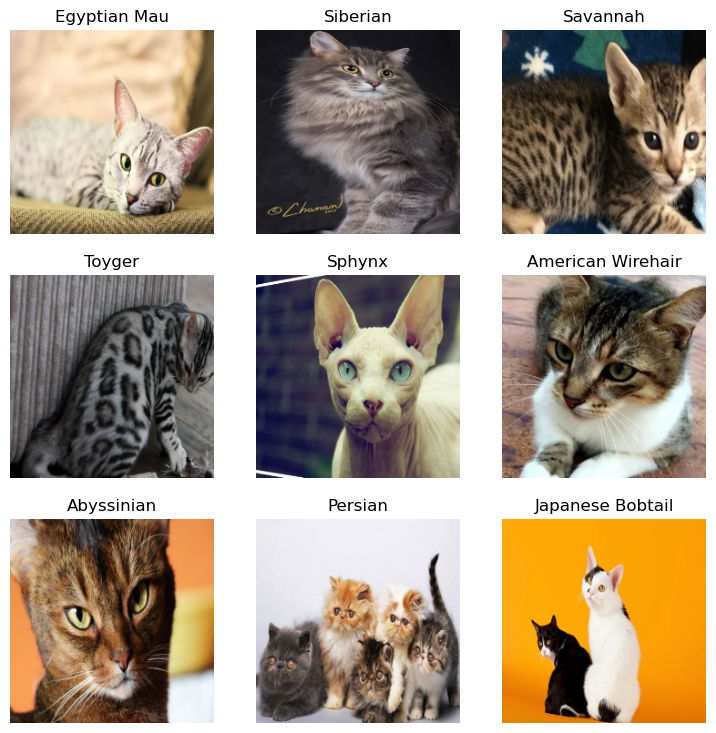

In [58]:
# dls.summary(path)
dls.show_batch(max_n=9)


Output shape: torch.Size([16, 768])


Minimum/10: 1.32e-03, steepest point: 3.02e-05
Slide: 1.10e-02, Valley: 7.59e-05


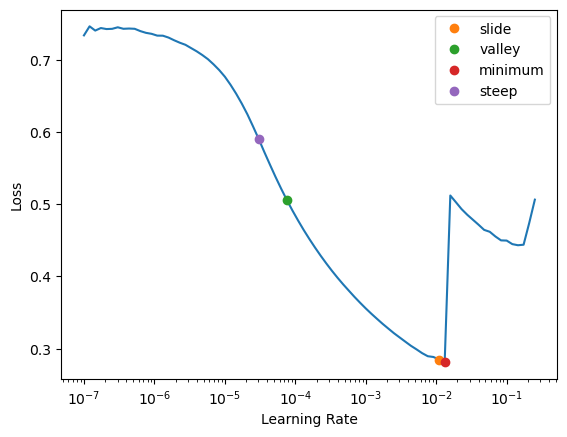

In [59]:
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from fastai.vision.all import *
import timm

# Define the CustomHead class with shape inspection
class CustomHead(nn.Module):
    def __init__(self, nf, n_out):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(nf, n_out)

    def forward(self, x):
        if x.dim() == 2:  # No spatial dimensions (1D features per image)
            # print("Input is 2D, skipping pooling.")
            x = self.flatten(x)
        elif x.dim() == 4:  # Regular case: [batch_size, channels, height, width]
            x = self.pool(x)
            # print(f"Shape after pooling: {x.shape}")
            x = self.flatten(x)
        else:
            raise ValueError(f"Unexpected input dimension: {x.dim()} dimensions.")
        # print(f"Shape after flattening: {x.shape}")
        x = self.linear(x)
        return x

# Create the model
# model_name = 'resnet18'  # Replace with your model name
model_name = 'convnext_tiny'  # Replace with your model name
# model_name = 'convnext_large'  # Replace with your model name
the_model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=0)  # num_classes=0 to exclude the final layer

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
the_model.to(device)

# Inspect the output shape
x, _ = dls.one_batch()
x = x.to(device)  # Move the input tensor to the same device as the model
with torch.no_grad():
    output = the_model(x)
print(f"Output shape: {output.shape}")

# Extract the number of features
nf = output.shape[1] if output.dim() == 4 else output.shape[-1]  # Handle cases where output is 1D or 4D

# Combine the backbone and custom head
model = nn.Sequential(
    the_model,
    CustomHead(nf=nf, n_out=len(dls.vocab))
)

# Create the learner
learn = Learner(
    dls,
    model,
    loss_func=BCEWithLogitsLoss(),
    metrics=accuracy_multi,
).to_bf16()

lr_slide, lr_valley, lr_min, lr_steep = learn \
    .lr_find(suggest_funcs=(slide, valley, minimum, steep))
    
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")
print(f"Slide: {lr_slide:.2e}, Valley: {lr_valley:.2e}")

In [21]:
learn.fine_tune??

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    *,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Source:   
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      ~/miniconda3/envs/work/lib/python3.11/site-packages/fastai/callback/schedule.py
Type:      method

In [60]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.106171,0.103212,0.977778,00:50
1,0.098472,0.096077,0.977778,02:16
2,0.083205,0.082258,0.977778,00:55


In [61]:
learn.unfreeze()

SuggestedLRs(valley=0.00010964782268274575)

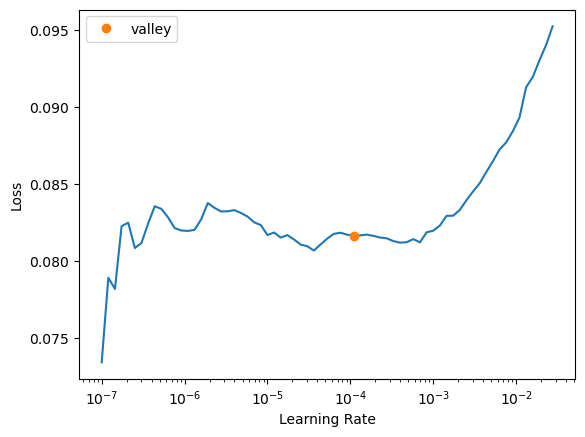

In [62]:
learn.lr_find()

In [63]:
learn.fit_one_cycle(3, 3e-4)

In [64]:
# learn = vision_learner(dls, model, metrics=error_rate)
learn = Learner(
    dls,
    model,
    loss_func=BCEWithLogitsLoss(),
    metrics=accuracy_multi,
).to_bf16()
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.109528,0.112748,0.977778,02:06
1,0.107760,0.107544,0.977778,-1:59:29
2,0.106793,0.106624,0.977778,00:44


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.106667,0.106600,0.977778,00:50
1,0.106642,0.106578,0.977778,00:50
2,0.104429,0.105097,0.977778,00:45
3,0.099321,0.099008,0.977778,00:50
4,0.081396,0.076963,0.977932,00:49
5,0.065061,0.067847,0.978809,02:16
6,0.055863,0.062828,0.980356,00:49
7,0.050630,0.056912,0.981645,-1:59:30
8,0.045751,0.053662,0.982264,00:45
9,0.040829,0.053180,0.982109,00:49


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

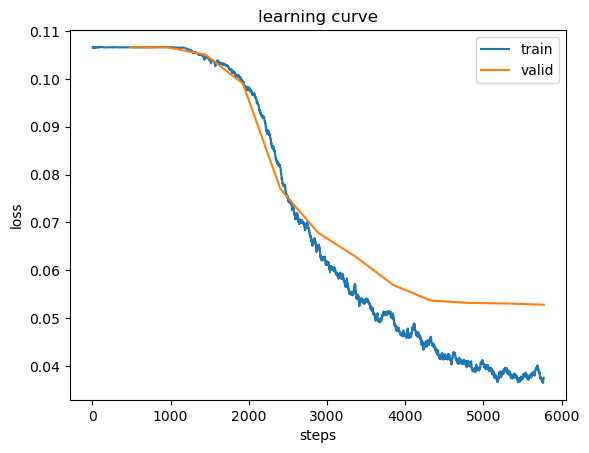

In [65]:
learn.recorder.plot_loss()

In [30]:
learn.fine_tune??

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    *,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Source:   
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      ~/miniconda3/envs/work/lib/python3.11/site-packages/fastai/callback/schedule.py
Type:      method

In [66]:
learn.fine_tune(50, 1e-3, freeze_epochs=3)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.051598,0.058845,0.979376,00:48
1,0.065267,0.064209,0.979995,02:17
2,0.063686,0.061405,0.979479,-1:59:29


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.039195,0.047281,0.983140,00:50
1,0.037628,0.047888,0.983088,02:16
2,0.033334,0.046650,0.984481,00:55
3,0.030508,0.045035,0.985357,00:53
4,0.027249,0.048321,0.984274,-1:59:26
5,0.026136,0.049602,0.983965,02:16
6,0.027137,0.050765,0.983707,00:55
7,0.027988,0.045997,0.984996,-1:59:29
8,0.026292,0.053859,0.983656,00:50
9,0.025609,0.052792,0.984068,02:16


RuntimeError: File export.pkl cannot be opened.

In [67]:
learn.export('export.pkl')

In [68]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

ValueError: not enough values to unpack (expected 3, got 2)

In [69]:
interp.most_confused(min_val=5)

ValueError: not enough values to unpack (expected 3, got 2)

In [47]:
from fastai.vision.all import PILImage
from PIL import Image
import numpy as np

# Debug: Check if learn object is loaded
try:
    print(f"Model loaded: {learn}")
except NameError:
    print("Error: 'learn' object is not defined or not loaded.")

# Debug: Check if dls object is loaded
try:
    print(f"DataLoaders loaded: {dls}")
    print(f"Vocabulary: {dls.vocab}")
except NameError:
    print("Error: 'dls' object is not defined or not loaded.")
except AttributeError:
    print("Error: 'dls' object does not have the expected attributes.")


def perform_prediction(img_path, show_image=True):
    try:
        img = PILImage.create(img_path)
        if show_image: img.show()
        # print("Image loaded successfully.")
        # print(f"Image shape: {img.shape}")
        # print(f"Image type: {type(img)}")
    except Exception as e:
        print(f"Error loading image: {e}")

    # Predict on a new image
    try:
        pred, pred_idx, probs = learn.predict(img)
        probs = sigmoid(probs)
        # print(f"Predicted labels: {pred}")
        # print(f"Prediction indices: {pred_idx}")
        # print(f"Probabilities: {probs}")
    except Exception as e:
        print(f"Error in prediction: {e}")

    # Predict on a new image
    try:
        not_a_pet_idx = list(dls.vocab).index('not-a-pet')
        # print(f"Index of 'not-a-pet' in vocabulary: {not_a_pet_idx}")
    except Exception as e:
        print(f"Error finding 'not-a-pet' in vocabulary: {e}")

    # Set a threshold
    threshold = 0.2
    is_not_pet = probs[not_a_pet_idx] > threshold 

    if is_not_pet:
        return "This is not a pet image."
    else:
        # Get the top 5 predictions
        top5_idx = probs.argsort(descending=True)[:5]
        top5_probs = probs[top5_idx]
        top5_breeds = [dls.vocab[i] for i in top5_idx]

        # Format the output
        result = "Top 5 predictions:\n"
        for breed, prob in zip(top5_breeds, top5_probs):
            result += f"{breed}: {prob:.4f}\n"
        
        return result

Model loaded: <fastai.learner.Learner object at 0x7f6250150ad0>
DataLoaders loaded: <fastai.data.core.DataLoaders object at 0x7f6250158810>
Vocabulary: ['Abyssinian', 'Affenpinscher', 'Afghan Hound', 'Africanis', 'Airedale Terrier', 'Akbash', 'Akita', 'Aksaray Malaklisi', 'Alano Español', 'Alapaha Blue Blood Bulldog', 'Alaskan Husky', 'Alaskan Klee Kai', 'Alaskan Malamute', 'Alpine Dachsbracke', 'American Bulldog', 'American Bully', 'American Cocker Spaniel', 'American English Coonhound', 'American Foxhound', 'American Hairless Terrier', 'American Pit Bull Terrier', 'American Staffordshire Terrier', 'American Water Spaniel', 'Anglo-Français de Petite Vénerie', 'Appenzeller Sennenhund', 'Ariège Pointer', 'Ariégeois', 'Armenian Gampr', 'Artois Hound', 'Australian Cattle Dog', 'Australian Silky Terrier', 'Australian Stumpy Tail Cattle Dog', 'Austrian Black Hound', 'Austrian Tan Hound', 'Azawakh', 'Bakharwal', 'Banjara Hound', 'Bankhar Dog', 'Barak hound', 'Barbado da Terceira', 'Barbet', 

/opt/miniconda3/envs/work/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/opt/miniconda3/envs/work/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


This is a pet image of breed: Basset Hound


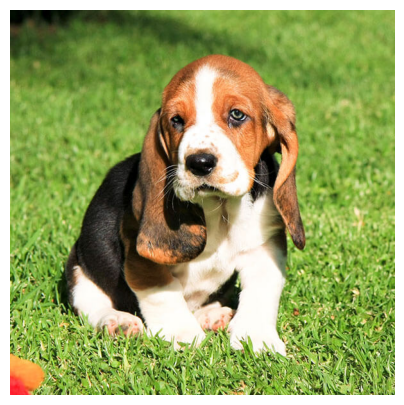

In [48]:
img_path = Path('images/Basset Hound/0c85043c-8c36-4ee6-983a-74fbb98a66ab.jpg')
print(perform_prediction(img_path))

